# Beam Blockage for SAIL

In [1]:
import pyart
import wradlib as wrl
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
radar = pyart.io.read('/home/zsherman/Downloads/xprecipradar_guc_volume_20220217-230559.b1.nc')

In [3]:
radar.fields.keys()

dict_keys(['DBZ', 'VEL', 'WIDTH', 'ZDR', 'PHIDP', 'RHOHV', 'NCP', 'SNR', 'DBZhv'])

In [4]:
display = pyart.graph.RadarMapDisplay(radar)

/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

/home/zsherman/dev/pyart/pyart/graph/radarmapdisplay.py:279: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Lambert Conformal.
  warnings.warn(


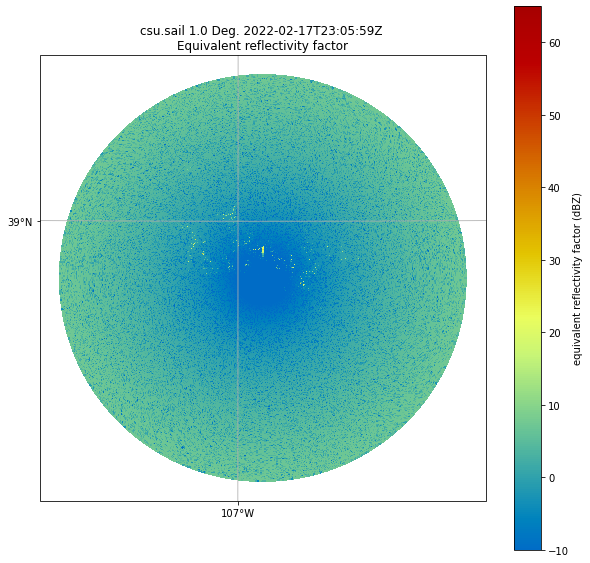

In [5]:
fig = plt.figure(figsize=(10, 10))
display.plot_ppi_map('DBZ', 0)

In [6]:
radar.altitude['data']

masked_array(data=[3149.19995117],
             mask=False,
       fill_value=1e+20)

In [18]:
tif_file = '/home/zsherman/Downloads/sail.tif'

In [140]:
def beam_block(radar, tif_file, radar_height_offset=10.0,
               beam_width=1.0):
    """
    Beam Block Radar Calculation.
    Parameters
    ----------
    radar : Radar
        Radar object used.
    tif_name : string
        Name of geotiff file to use for the
        calculation.
    radar_height_offset : float
        Add height to the radar altitude for radar towers.
    Other Parameters
    ----------------
    beam_width : float
        Radar's beam width for calculation.
        Default value is 1.0.
    Returns
    -------
    pbb_all : array
        Array of partial beam block fractions for each
        gate in all sweeps.
    cbb_all : array
        Array of cumulative beam block fractions for
        each gate in all sweeps.
    References
    ----------
    Bech, J., B. Codina, J. Lorente, and D. Bebbington,
    2003: The sensitivity of single polarization weather
    radar beam blockage correction to variability in the
    vertical refractivity gradient. J. Atmos. Oceanic
    Technol., 20, 845–855
    Heistermann, M., Jacobi, S., and Pfaff, T., 2013:
    Technical Note: An open source library for processing
    weather radar data (wradlib), Hydrol. Earth Syst.
    Sci., 17, 863-871, doi:10.5194/hess-17-863-2013
    Helmus, J.J. & Collis, S.M., (2016). The Python ARM
    Radar Toolkit (Py-ART), a Library for Working with
    Weather Radar Data in the Python Programming Language.
    Journal of Open Research Software. 4(1), p.e25.
    DOI: http://doi.org/10.5334/jors.119
    """
    # Opening the tif file and getting the values ready to be
    # converted into polar values.
    rasterfile = tif_file
    data_raster = wrl.io.open_raster(rasterfile)
    rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(
        data_raster, nodata=None)
    #rastervalues_, rastercoords_, proj = wrl.georef.extract_raster_dataset(data_raster, nodata=-32768.)
    sitecoords = (np.float(radar.longitude['data']),
                  np.float(radar.latitude['data']),
                  np.float(radar.altitude['data'] + radar_height_offset))
    pbb_arrays = []
    cbb_arrays = []
    _range = radar.range['data']
    beamradius = wrl.util.half_power_radius(_range, beam_width)
    # Cycling through all sweeps in the radar object.
    print('Calculating beam blockage.')
    for i in range(len(radar.sweep_start_ray_index['data'])):
        index_start = radar.sweep_start_ray_index['data'][i]
        index_end = radar.sweep_end_ray_index['data'][i] + 1
        elevs = radar.elevation['data'][index_start:index_end]
        azimuths = radar.azimuth['data'][index_start:index_end]
        rg, azg = np.meshgrid(_range, azimuths)
        rg, eleg = np.meshgrid(_range, elevs)
        nrays = azimuths.shape[0]              # number of rays
        nbins = radar.ngates                   # number of range bins
        bw = beam_width                        # half power beam width (deg)
        range_res = 60.                       # range resolution (meters)
        el = radar.fixed_angle['data'][i]
        coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
        coords = wrl.georef.spherical_to_proj(rg, azg, eleg,
                                              sitecoords, proj=proj)
        lon = coords[..., 0]
        lat = coords[..., 1]
        alt = coords[..., 2]
        polcoords = coords[..., :2]
        rlimits = (lon.min(), lat.min(), lon.max(), lat.max())

        #Clip the region inside our bounding box
        ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
        rastercoords = rastercoords[ind[0]:ind[3], ind[0]:ind[2], ...]
        rastervalues = rastervalues[ind[0]:ind[3], ind[0]:ind[2]]
        polarvalues = wrl.ipol.cart_to_irregular_spline(
            rastercoords, rastervalues, polcoords, order=3,
            prefilter=False)
        # Calculate partial beam blockage using wradlib.
        pbb = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
        print(pbb.min())
        print(pbb.max())
        pbb = np.ma.masked_invalid(pbb)
        pbb[pbb < 0] = 0.0
        pbb[pbb > 1] = 1.0
        pbb_arrays.append(pbb)
        # Calculate cumulative beam blockage using wradlib.
        cbb = wrl.qual.cum_beam_block_frac(pbb)
        cbb_arrays.append(cbb)
    pbb_all = np.ma.concatenate(pbb_arrays)
    cbb_all = np.ma.concatenate(cbb_arrays)
    del data_raster
    return pbb_all, cbb_all

In [141]:
def pbb_to_dict(pbb_all):
    """ Function that takes the pbb_all array and turns
    it into a dictionary to be used and added to the
    pyart radar object. """
    pbb_dict = {}
    pbb_dict['coordinates'] = 'elevation azimuth range'
    pbb_dict['units'] = '1'
    pbb_dict['data'] = pbb_all
    pbb_dict['standard_name'] = 'partial_beam_block'
    pbb_dict['long_name'] = 'Partial Beam Block Fraction'
    pbb_dict['comment'] = 'Partial beam block fraction due to terrain.'
    return pbb_dict


def cbb_to_dict(cbb_all):
    """ Function that takes the cbb_all array and turns
    it into a dictionary to be used and added to the
    pyart radar object. """
    cbb_dict = {}
    cbb_dict['coordinates'] = 'elevation azimuth range'
    cbb_dict['units'] = '1'
    cbb_dict['data'] = cbb_all
    cbb_dict['standard_name'] = 'cumulative_beam_block'
    cbb_dict['long_name'] = 'Cumulative Beam Block Fraction'
    cbb_dict['comment'] = 'Cumulative beam block fraction due to terrain.'
    return cbb_dict

In [142]:
pbb, cbb = beam_block(radar, tif_file, radar_height_offset=10.0, beam_width=1.0)

/tmp/ipykernel_19718/389964371.py:51: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sitecoords = (np.float(radar.longitude['data']),
/tmp/ipykernel_19718/389964371.py:52: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(radar.latitude['data']),
/tmp/ipykernel_19718/389964371.py:53: DeprecationWarning: `np.float` is a deprecated alia

Calculating beam blockage.
-1.2091031789350578e-06
1.000001209103179
-1.2091031789350578e-06
1.000001209103179
0.0
1.0
0.0
1.000001209103179
-1.2091031789350578e-06
1.0
-1.2091031789350578e-06
1.000001209103179
-1.2091031789350578e-06
1.000001209103179
-1.2091031789350578e-06
1.000001209103179


In [122]:
radar.latitude

{'_FillValue': -9999.0,
 'long_name': 'Latitude',
 'units': 'degree_N',
 'standard_name': 'latitude',
 'valid_min': -90.0,
 'valid_max': 90.0,
 'data': masked_array(data=[38.89838028],
              mask=False,
        fill_value=1e+20)}

In [123]:
radar.range['data'][0:4]

masked_array(data=[-112.830795 ,  -52.889847 ,    7.0511017,   66.99205  ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [124]:
radar.gate_latitude['data'].max()

39.260605

In [152]:
cbb.min()

0.0

In [145]:
pbb_dict = pbb_to_dict(pbb)
cbb_dict = cbb_to_dict(cbb)
radar.add_field('partial_beam_blockage', pbb_dict, replace_existing=True)
radar.add_field('cumulative_beam_blockage', cbb_dict, replace_existing=True)

In [146]:
radar.fields['partial_beam_blockage']['data'].min()

0.0

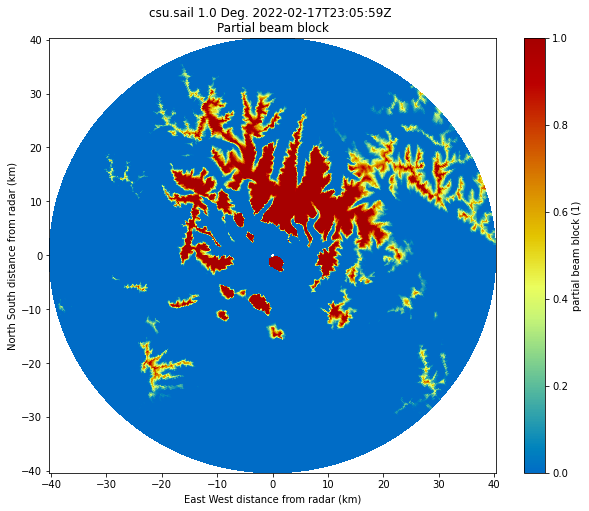

In [147]:
fig = plt.figure(figsize=(10, 8))
display.plot_ppi('partial_beam_blockage', 0, cmap='pyart_HomeyerRainbow')
plt.savefig('/home/zsherman/pbb_sail.png')

In [158]:
pbb[:, 0]

masked_array(data=[1., 1., 1., ..., 0., 0., 0.],
             mask=False,
       fill_value=1e+20)

## See the blockage diminish as fixed angle increases

/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

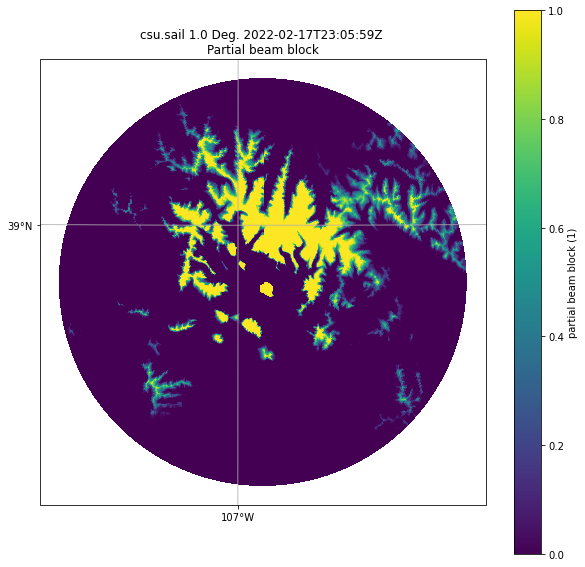

/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

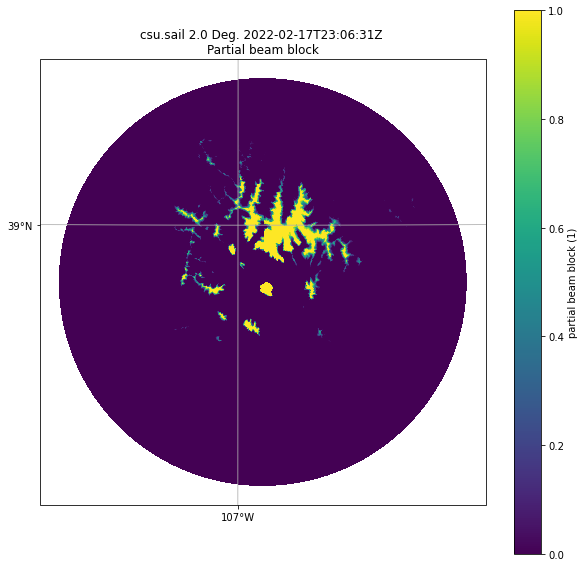

/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

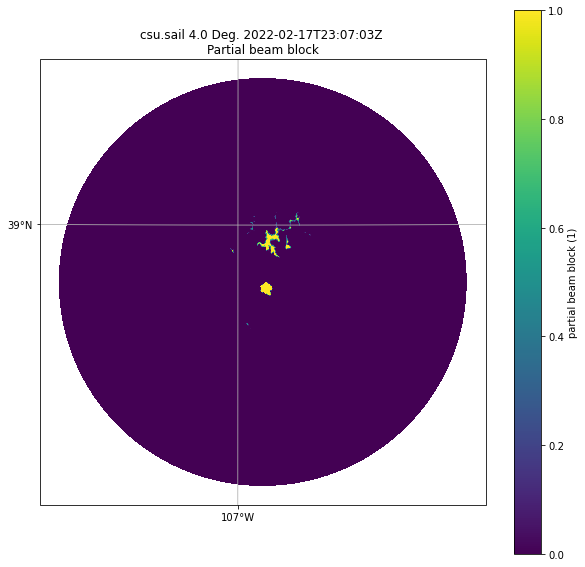

/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

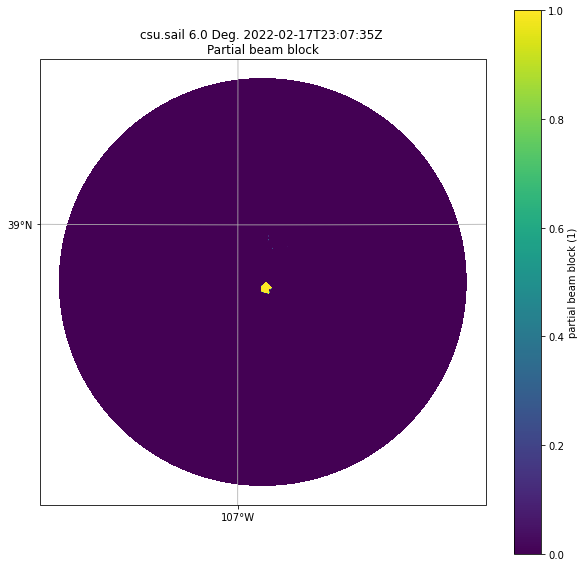

/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

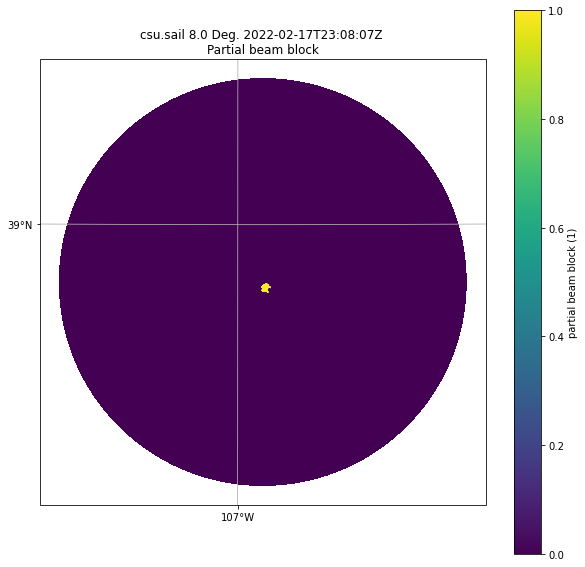

/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

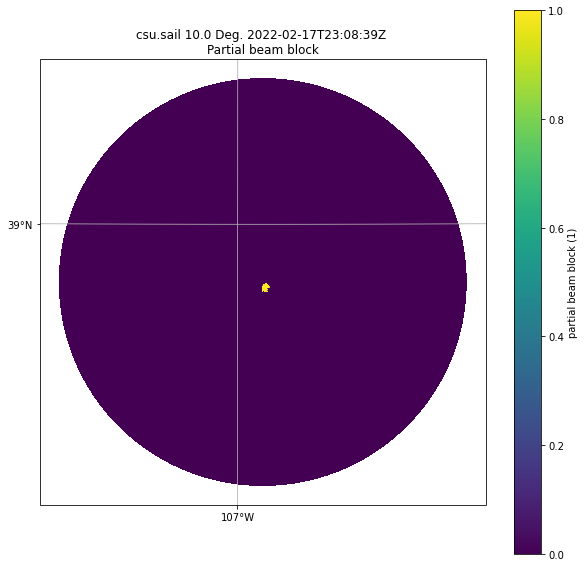

/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

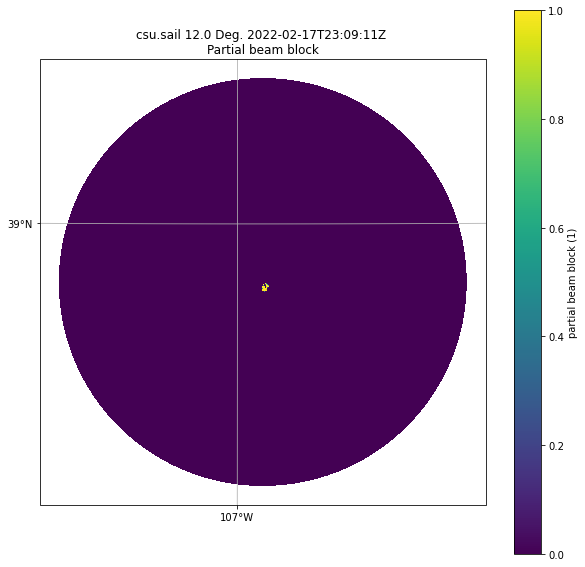

/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/home/zsherman/anaconda3/envs/pyart_env/lib/python3.8/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np

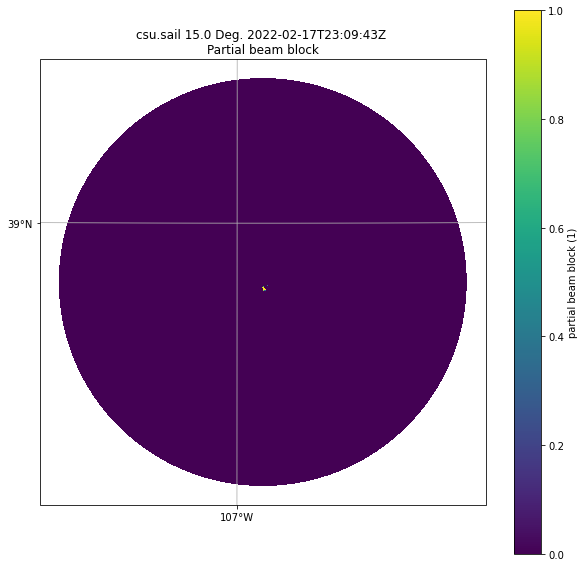

In [159]:
for i in range(radar.nsweeps):
    fig = plt.figure(figsize=(10, 10))
    radar_foo = radar.extract_sweeps([i])
    display_foo = pyart.graph.RadarMapDisplay(radar_foo)
    display.plot_ppi_map('partial_beam_blockage', i)
    plt.show()

## Still need to find why cumulative beam blockage isn't working...

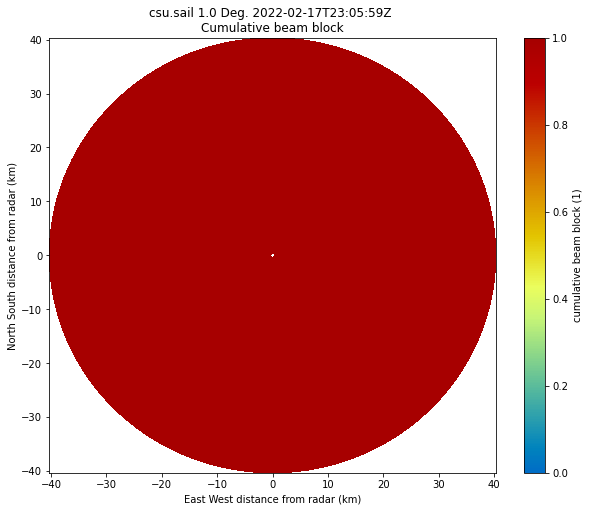

In [164]:
fig = plt.figure(figsize=(10, 8))
display.plot_ppi('cumulative_beam_blockage', 0, cmap='pyart_HomeyerRainbow', vmin=0, vmax=1)

In [165]:
radar.fields['cumulative_beam_blockage']['data'].mean()

0.99175790544643

In [163]:
radar.fields['cumulative_beam_blockage']['data'][:, 0]

masked_array(data=[1., 1., 1., ..., 0., 0., 0.],
             mask=False,
       fill_value=1e+20)

## Part of me believes that lat and lon info is wrong, so the beam blockage assumes the radar is in the mountain in the center of the ppi

In [ ]:
radar.azimuth['data'].shape

In [ ]:
radar.fields['DBZ']['data'].shape